In [12]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
from Functions import pivot_data_by_HSA, merge_and_rename_data, add_changes_by_week, create_column_names, create_collated_weekly_data
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']

Functions

In [13]:
def prep_training_test_data_period(
    data, no_weeks, weeks_in_future, geography, weight_col, keep_output
):
    ## Get the weeks for the x and y datasets
    x_weeks = []
    y_weeks = []
    y_weeks_to_check = []  # check these weeks to see if any of them are equal to 1
    for week in no_weeks:
        test_week = int(week) + weeks_in_future
        x_weeks.append("_" + num2words(week) + "_")
        for week_y in range(week + 1, test_week + 1):
            y_weeks_to_check.append("_" + num2words(week_y) + "_")
        y_weeks.append("_" + num2words(test_week) + "_")

    ## Divide up the test/train split
    # if is_geographic:
    # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
    # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all = pd.DataFrame()
    missing_data = []
    ## Now get the training data
    k = 0
    for x_week in x_weeks:
        y_week = y_weeks[k]
        k += 1

        weeks_x = [col for col in data.columns if x_week in col]
        columns_x = [geography] + weeks_x + [weight_col]
        data_x = data[columns_x]

        weeks_y = [col for col in data.columns if y_week in col]
        columns_y = [geography] + weeks_y
        data_y = data[columns_y]
        ### now add the final column to the y data that has it so that it's if any week in the trhee week perdiod exceeded 15
        train_week = w2n.word_to_num(x_week.replace("_", ""))
        target_week = w2n.word_to_num(y_week.replace("_", ""))
        y_weeks_to_check = []
        for week_to_check in range(train_week + 1, target_week + 1):
            y_weeks_to_check.append("_" + num2words(week_to_check) + "_")

        y_weeks_to_check = [week + "beds_over_10_100k" for week in y_weeks_to_check]
        columns_to_check = [
            col for col in data.columns if any(week in col for week in y_weeks_to_check)
        ]
        y_over_in_period = data[columns_to_check].apply(max, axis=1)
        data_y = pd.concat([data_y, y_over_in_period], axis=1)
        # ensure they have the same amount of data
        # remove rows in test_data1 with NA in test_data2
        data_x = data_x.dropna()
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        # remove rows in test_data2 with NA in test_data1
        data_y = data_y.dropna()
        data_y = data_y[data_y[geography].isin(data_x[geography])]
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        data_x_no_HSA = len(data_x[geography].unique())

        missing_data.append(
            (
                (len(data[geography].unique()) - data_x_no_HSA)
                / len(data[geography].unique())
            )
            * 100
        )
        # get weights
        # weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

        X_week = data_x.iloc[:, 1 : len(columns_x)]  # take away y, leave weights for mo
        y_week = data_y.iloc[:, -1]

        y_week = y_week.astype(int)
        weights = X_week.iloc[:, -1]
        if keep_output:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 1
            ]  # remove the weights and leave "target" for that week

            # rename columns for concatenation
            X_week.columns = range(1, len(data_x.columns) - 1)
        else:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 2
            ]  # remove the weights and  "target" for that week

            X_week.columns = range(
                1, len(data_x.columns) - 2
            )  # remove the weights and  "target" for that week

        y_week.columns = range(1, len(data_y.columns) - 2)
        X_data = pd.concat([X_data, X_week])
        y_data = pd.concat([y_data, y_week])

        weights_all = pd.concat([weights_all, weights])

    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return (X_data, y_data, weights_all, missing_data)

def prep_training_test_data(
    data, no_weeks, weeks_in_future, geography, weight_col, keep_output
):
    ## Get the weeks for the x and y datasets
    x_weeks = []
    y_weeks = []
    for week in no_weeks:
        test_week = int(week) + weeks_in_future
        x_weeks.append("_" + num2words(week) + "_")
        y_weeks.append("_" + num2words(test_week) + "_")

    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all = pd.DataFrame()
    missing_data = []
    ## Now get the training data
    k = 0
    for x_week in x_weeks:
        y_week = y_weeks[k]
        k += 1
        weeks_x = [col for col in data.columns if x_week in col]
        columns_x = [geography] + weeks_x + [weight_col]
        data_x = data[columns_x]

        weeks_y = [col for col in data.columns if y_week in col]
        columns_y = [geography] + weeks_y
        data_y = data[columns_y]
        # ensure they have the same amount of data
        # remove rows in test_data1 with NA in test_data2
        data_x = data_x.dropna()
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        # remove rows in test_data2 with NA in test_data1
        data_y = data_y.dropna()
        data_y = data_y[data_y[geography].isin(data_x[geography])]
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        data_x_no_HSA = len(data_x[geography].unique())

        missing_data.append(
            (
                (len(data[geography].unique()) - data_x_no_HSA)
                / len(data[geography].unique())
            )
            * 100
        )
        # get weights
        # weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

        X_week = data_x.iloc[:, 1 : len(columns_x)]  # take away y, leave weights for mo
        y_week = data_y.iloc[:, -1]

        y_week = y_week.astype(int)
        weights = X_week.iloc[:, -1]
        if keep_output:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 1
            ]  # remove the weights and leave "target" for that week

            # rename columns for concatenation
            X_week.columns = range(1, len(data_x.columns) - 1)
        else:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 2
            ]  # remove the weights and  "target" for that week

            X_week.columns = range(
                1, len(data_x.columns) - 2
            )  # remove the weights and  "target" for that week

            # rename columns for concatenation
        y_week.columns = range(1, len(data_y.columns) - 1)
        X_data = pd.concat([X_data, X_week])
        y_data = pd.concat([y_data, y_week])

        weights_all = pd.concat([weights_all, weights])

    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return (X_data, y_data, weights_all, missing_data)


def prep_training_test_data_shifted(data, no_weeks, weeks_in_future, geography, weight_col, keep_output):
## Get the weeks for the x and y datasets   
    x_weeks = []  
    y_weeks = []
    y_weeks_to_check = [] #check these weeks to see if any of them are equal to 1
    for week in no_weeks:
        test_week = int(week) + weeks_in_future
        x_weeks.append('_' + num2words(week) + '_')
        for week_y in range(week+2, test_week+2):
                y_weeks_to_check.append('_' + num2words(week_y) + '_')
        y_weeks.append('_' + num2words(test_week) + '_')
    
## Divide up the test/train split
    #if is_geographic:
        # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
        # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all =  pd.DataFrame()
    missing_data = []
    ## Now get the training data 
    k = 0
    for x_week in x_weeks:
            y_week = y_weeks[k]
            k +=1

            weeks_x = [col for col in data.columns if x_week in col]
            columns_x  = [geography] + weeks_x + [weight_col]
            data_x = data[columns_x]

            weeks_y = [col for col in data.columns if y_week in col]
            columns_y  = [geography] + weeks_y
            data_y = data[columns_y]
            ### now add the final column to the y data that has it so that it's if any week in the trhee week perdiod exceeded 15
            train_week = w2n.word_to_num(x_week.replace("_", ""))
            target_week =  w2n.word_to_num(y_week.replace("_", ""))
            y_weeks_to_check = []
            for week_to_check in range(train_week + 1, target_week + 1):
                y_weeks_to_check.append('_' + num2words(week_to_check) + '_')

            y_weeks_to_check = [week + 'beds_over_10_100k' for week in y_weeks_to_check]
            columns_to_check = [col for col in data.columns if any(week in col for week in y_weeks_to_check)]
            y_over_in_period = data[columns_to_check].apply(max, axis=1)
            data_y = pd.concat([data_y, y_over_in_period], axis=1)
            # ensure they have the same amount of data
            #remove rows in test_data1 with NA in test_data2
            data_x = data_x.dropna()
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            # remove rows in test_data2 with NA in test_data1
            data_y = data_y.dropna()
            data_y = data_y[data_y[geography].isin(data_x[geography])]
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            data_x_no_HSA = len(data_x[geography].unique())

            missing_data.append(((len(data[geography].unique()) - data_x_no_HSA)/len(data[geography].unique())) * 100)
            # get weights 
            #weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

            X_week = data_x.iloc[:, 1:len(columns_x)]  # take away y, leave weights for mo
            y_week = data_y.iloc[:, -1] 
            
            y_week = y_week.astype(int)

            weights = X_week.iloc[:, -1] 
            if keep_output:
                X_week = X_week.iloc[:, :len(X_week.columns)-1] # remove the weights and leave "target" for that week

                #rename columns for concatenation 
                X_week.columns = range(1, len(data_x.columns) -1)
            else:
                X_week = X_week.iloc[:, :len(X_week.columns)-2] # remove the weights and  "target" for that week

                X_week.columns = range(1, len(data_x.columns) -2)# remove the weights and  "target" for that week

            y_week.columns = range(1, len(data_y.columns) -2)
            X_data = pd.concat([X_data, X_week])
            y_data = pd.concat([y_data, y_week]) 
        
            weights_all =  pd.concat([weights_all, weights]) 


    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return(X_data, y_data, weights_all, missing_data)

In [14]:
def cross_validation_leave_geo_out(data, geography_column, geo_split, no_iterations, cv, classifier, param_grid, no_iterations_param, no_weeks_train,no_weeks_test, weeks_in_future, weight_col, keep_output, time_period):
        best_hyperparameters_per_iter = []
        auROC_per_iter = []

        for i in range(no_iterations):
                #subset the HSAs from the full dataset 
                geo_names = data[geography_column].unique()
                num_names_to_select = int(geo_split * len(geo_names))
                geos_for_sample = random.sample(list(geo_names), num_names_to_select)
                subset_HSAs_for_train = data[data[geography_column].isin(geos_for_sample)]
                subset_HSAs_for_test = data[~data[geography_column].isin(geos_for_sample)]

                #create training and test data
                if time_period == 'period':
                        X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data_period(subset_HSAs_for_train, no_weeks = no_weeks_train, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data_period(subset_HSAs_for_test, no_weeks = no_weeks_test, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        weights_train = weights_train[0]
                elif time_period == 'exact':
                        X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data(subset_HSAs_for_train, no_weeks = no_weeks_train, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col =weight_col,keep_output = keep_output)
                        X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data(subset_HSAs_for_test, no_weeks = no_weeks_test, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        weights_train = weights_train[0]
                elif time_period == 'shifted':
                        X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data_shifted(subset_HSAs_for_train, no_weeks = no_weeks_train, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data_shifted(subset_HSAs_for_test, no_weeks = no_weeks_test, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        weights_train = weights_train[0]
                random_search = RandomizedSearchCV(classifier, param_grid, n_iter=no_iterations_param, cv=cv, random_state=10)
                random_search.fit(X_sample_train, y_sample_train, sample_weight = weights_train)
                best_params = random_search.best_params_

        # Create the Decision Tree classifier with the best hyperparameters
                model = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')
                model_fit = model.fit(X_sample_train, y_sample_train, sample_weight=weights_train)
                y_pred = model_fit.predict_proba(X_sample_test)
                # Evaluate the accuracy of the model
                best_hyperparameters_per_iter.append(best_params)
                auROC_per_iter.append(roc_auc_score(y_sample_test, y_pred[:,1]))
        
        return best_hyperparameters_per_iter[np.argmax(np.array(auROC_per_iter))]


In [15]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly.csv")

# Threshold of 10 per 100k

In [21]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
data_by_HSA['health_service_area_number']
data_by_HSA['health_service_area']
#data_by_HSA['HSA_ID'] = data_by_HSA['health_service_area_number'].astype(str) + '' + data_by_HSA['health_service_area'].apply(lambda x: x.split()[0])
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)

data_by_HSA['beds_over_10_100k'] = (data_by_HSA['beds_weekly'] > 10)*1

# remove HSAs that have missing data in specific columns

data_by_HSA = data_by_HSA.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])

for i, week in enumerate(data_by_HSA['date'].unique()):
    data_by_HSA.loc[data_by_HSA['date'] == week, 'week'] = i

## pivot 
data_by_HSA_cases = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'cases_weekly')
data_by_HSA_deaths = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'deaths_weekly')
data_by_HSA_admissions = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'admits_weekly')
data_by_HSA_icu = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'icu_weekly')
data_by_HSA_beds = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'beds_weekly')
data_by_HSA_percent_beds = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'perc_covid')
data_by_HSA_over_10_100k = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'beds_over_10_100k')

## merge 
data_by_HSA_cases_deaths = merge_and_rename_data(data_by_HSA_cases, data_by_HSA_deaths,'week','cases', 'deaths')
data_by_HSA_admits_icu_weekly = merge_and_rename_data(data_by_HSA_admissions, data_by_HSA_icu,'week','admits', 'icu')
data_by_HSA_beds_perc_weekly = merge_and_rename_data(data_by_HSA_beds, data_by_HSA_percent_beds,'week','beds', 'perc_covid')
data_by_HSA_cases_deaths_admits_icu = pd.merge(data_by_HSA_cases_deaths, data_by_HSA_admits_icu_weekly, on='week')
data_by_HSA_cases_deaths_admits_icu_beds = pd.merge(data_by_HSA_cases_deaths_admits_icu, data_by_HSA_beds_perc_weekly, on='week')

## add outcome variable 

old_column_names = data_by_HSA_over_10_100k.columns
new_column_names = [str(col) + '_beds_over_10_100k' for col in old_column_names]
new_column_names = dict(zip(old_column_names, new_column_names))
data_by_HSA_over_10_100k.rename(columns=new_column_names, inplace=True)
data_by_HSA_cases_deaths_admits_icu_beds = pd.merge(data_by_HSA_cases_deaths_admits_icu_beds, data_by_HSA_over_10_100k, on='week')

data_by_HSA_cases_deaths_admits_icu_beds = data_by_HSA_cases_deaths_admits_icu_beds.reset_index()
data_by_HSA_cases_deaths_admits_icu_beds.columns = data_by_HSA_cases_deaths_admits_icu_beds.columns.str.replace(',', '')


all_HSA_ID_weekly_data = add_changes_by_week(data_by_HSA_cases_deaths_admits_icu_beds, "beds_over_10_100k")


categories_for_subsetting = ['cases', 'deaths', 'admits', 'icu', 'beds', 'perc_covid', 'cases_delta', 'deaths_delta', 'admits_delta', 'icu_delta', 'beds_delta', 'perc_covid_delta','beds_over_10_100k']
num_of_weeks = len(data_by_HSA_cases_deaths_admits_icu_beds)
column_names = create_column_names(categories_for_subsetting, num_of_weeks)


all_HSA_ID_weekly_data = create_collated_weekly_data(data_by_HSA_cases_deaths_admits_icu_beds, data_by_HSA, categories_for_subsetting, 'HSA_ID', column_names)

weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight']]
weights_df = weights_df.rename(columns = {'HSA_ID': 'HSA_ID', 'weight':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
all_HSA_ID_weekly_data = all_HSA_ID_weekly_data.join(weights_df['weight'])

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_68032/3765265600.py:1: DtypeWarning: Columns (41,43,44,45,46,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py:359: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weekly_data_frame.insert(column_index + 1, new_column_name, diff)
/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py:359: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

In [22]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(1, int(123*2/3) + 1), weeks_in_future = 3,   geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(int(123*2/3) + 1, 120), weeks_in_future = 3,   geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights = weights[0].to_numpy()

Accuracy: 0.8236229530383001
auROC: 0.91227701342882
[[ 3725   536]
 [ 4677 20618]]


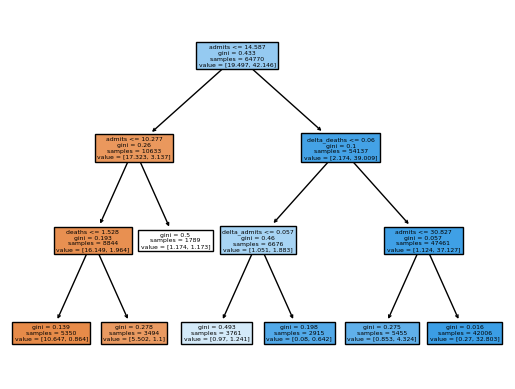

In [25]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
no_weeks_train =  range(1, int(123*2/3) + 1)  # across entire training period
no_weeks_test = range(int(123*2/3) + 1, 120) # across entire training period
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  
no_iterations_param = 10  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }
clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations
# Perform Randomized Search with 10-fold cross-validation

best_params = cross_validation_leave_geo_out(all_HSA_ID_weekly_data, geography_column=geography_column, geo_split=geo_split, no_iterations=no_iterations, cv=cv, classifier=clf, param_grid=param_grid, no_iterations_param=no_iterations_param, no_weeks_train=no_weeks_train, no_weeks_test=no_weeks_test, weeks_in_future=weeks_in_future, weight_col=weight_col, keep_output=keep_output, time_period='period')

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("auROC:", ROC) 

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_10_100k'], filled=True)
plt.savefig('Graphs/Full_classifier_3_week_period_unpruned_10_per_100k.png', dpi = 300)

# Threshold of 5 per 100k 

In [26]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
data_by_HSA['health_service_area_number']
data_by_HSA['health_service_area']
#data_by_HSA['HSA_ID'] = data_by_HSA['health_service_area_number'].astype(str) + '' + data_by_HSA['health_service_area'].apply(lambda x: x.split()[0])
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)

data_by_HSA['beds_over_5_100k'] = (data_by_HSA['beds_weekly'] > 5)*1  # Changed 10 to 5

# remove HSAs that have missing data in specific columns
data_by_HSA = data_by_HSA.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])

for i, week in enumerate(data_by_HSA['date'].unique()):
    data_by_HSA.loc[data_by_HSA['date'] == week, 'week'] = i

## pivot 
data_by_HSA_cases = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'cases_weekly')
data_by_HSA_deaths = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'deaths_weekly')
data_by_HSA_admissions = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'admits_weekly')
data_by_HSA_icu = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'icu_weekly')
data_by_HSA_beds = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'beds_weekly')
data_by_HSA_percent_beds = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'perc_covid')
data_by_HSA_over_5_100k = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'beds_over_5_100k')  # Changed 10 to 5

## merge 
data_by_HSA_cases_deaths = merge_and_rename_data(data_by_HSA_cases, data_by_HSA_deaths,'week','cases', 'deaths')
data_by_HSA_admits_icu_weekly = merge_and_rename_data(data_by_HSA_admissions, data_by_HSA_icu,'week','admits', 'icu')
data_by_HSA_beds_perc_weekly = merge_and_rename_data(data_by_HSA_beds, data_by_HSA_percent_beds,'week','beds', 'perc_covid')
data_by_HSA_cases_deaths_admits_icu = pd.merge(data_by_HSA_cases_deaths, data_by_HSA_admits_icu_weekly, on='week')
data_by_HSA_cases_deaths_admits_icu_beds = pd.merge(data_by_HSA_cases_deaths_admits_icu, data_by_HSA_beds_perc_weekly, on='week')

## add outcome variable 

old_column_names = data_by_HSA_over_5_100k.columns  # Changed 10 to 5
new_column_names = [str(col) + '_beds_over_5_100k' for col in old_column_names]  # Changed 10 to 5
new_column_names = dict(zip(old_column_names, new_column_names))
data_by_HSA_over_5_100k.rename(columns=new_column_names, inplace=True)
data_by_HSA_cases_deaths_admits_icu_beds = pd.merge(data_by_HSA_cases_deaths_admits_icu_beds, data_by_HSA_over_5_100k, on='week')  # Changed 10 to 5

data_by_HSA_cases_deaths_admits_icu_beds = data_by_HSA_cases_deaths_admits_icu_beds.reset_index()
data_by_HSA_cases_deaths_admits_icu_beds.columns = data_by_HSA_cases_deaths_admits_icu_beds.columns.str.replace(',', '')

all_HSA_ID_weekly_data = add_changes_by_week(data_by_HSA_cases_deaths_admits_icu_beds, "beds_over_5_100k")  # Changed 10 to 5

categories_for_subsetting = ['cases', 'deaths', 'admits', 'icu', 'beds', 'perc_covid', 'cases_delta', 'deaths_delta', 'admits_delta', 'icu_delta', 'beds_delta', 'perc_covid_delta','beds_over_5_100k']  # Changed 10 to 5
num_of_weeks = len(data_by_HSA_cases_deaths_admits_icu_beds)
column_names = create_column_names(categories_for_subsetting, num_of_weeks)

all_HSA_ID_weekly_data = create_collated_weekly_data(data_by_HSA_cases_deaths_admits_icu_beds, data_by_HSA, categories_for_subsetting, 'HSA_ID', column_names)

weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight']]
weights_df = weights_df.rename(columns = {'HSA_ID': 'HSA_ID', 'weight':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
all_HSA_ID_weekly_data = all_HSA_ID_weekly_data.join(weights_df['weight'])

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_68032/1941798326.py:1: DtypeWarning: Columns (41,43,44,45,46,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py:359: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weekly_data_frame.insert(column_index + 1, new_column_name, diff)
/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py:359: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

Accuracy: 0.8236229530383001
auROC: 0.9161762825043274
[[ 3725   536]
 [ 4677 20618]]


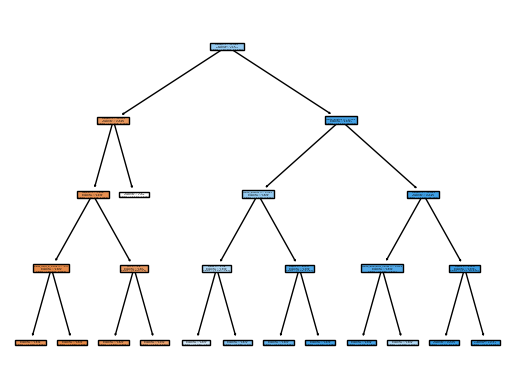

In [27]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
no_weeks_train =  range(1, int(123*2/3) + 1)  # across entire training period
no_weeks_test = range(int(123*2/3) + 1, 120) # across entire training period
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  
no_iterations_param = 10  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }
clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations
# Perform Randomized Search with 10-fold cross-validation

best_params = cross_validation_leave_geo_out(all_HSA_ID_weekly_data, geography_column=geography_column, geo_split=geo_split, no_iterations=no_iterations, cv=cv, classifier=clf, param_grid=param_grid, no_iterations_param=no_iterations_param, no_weeks_train=no_weeks_train, no_weeks_test=no_weeks_test, weeks_in_future=weeks_in_future, weight_col=weight_col, keep_output=keep_output, time_period='period')

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("auROC:", ROC) 

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_5_100k'], filled=True)
plt.savefig('Graphs/Full_classifier_3_week_period_unpruned_5_per_100k.png', dpi = 300)